In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Data_handler import Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 2 Loading the data

In [3]:
# Prepare data
Data_instance = Data()               # create instance of the class Data()
data = Data_instance.get_data()      # store the data of Data_instance

Data has been loaded from local files. Only data with more than 36 observations has been kept.


In [4]:
display(data)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746
...,...,...,...,...,...,...,...,...
1439403,90996,2008-03-31,0.008584,48790.0,2.35000,2834,0.001032,-0.010444
1439404,90996,2008-02-29,-0.127341,48585.0,2.33000,2834,0.001727,-0.021697
1439405,90996,2008-01-31,-0.178462,48585.0,2.67000,2834,0.001388,-0.062218
1439406,90996,2007-12-31,0.199262,48585.0,3.25000,2834,0.002384,-0.004405


# 3 Betting Against Beta

## Question a)

In [35]:
# Overview of the data
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [9]:
data = Data.get_rolling_beta() # Get the rolling betas from the data. This is a method from the class Data, in Data_handler.py
display(data)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258,-0.022190,-0.209829,NaN
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407,0.003373,-0.208513,NaN
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414,0.010490,-0.173379,NaN
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699,-0.027047,0.416007,NaN
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746,-0.029559,0.043806,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1439403,90996,2008-03-31,0.008584,48790.0,2.35000,2834,0.001032,-0.010444,-0.011476,0.007552,NaN
1439404,90996,2008-02-29,-0.127341,48585.0,2.33000,2834,0.001727,-0.021697,-0.023424,-0.129068,0.419406
1439405,90996,2008-01-31,-0.178462,48585.0,2.67000,2834,0.001388,-0.062218,-0.063606,-0.179850,0.419406
1439406,90996,2007-12-31,0.199262,48585.0,3.25000,2834,0.002384,-0.004405,-0.006789,0.196878,NaN


In [12]:
data_Qb = data.copy().dropna()
print("Initial number of observations: ", data.shape[0])
print("Final number of observations: \t", data_Qb.shape[0])

Initial number of observations:  1439408
Final number of observations: 	 412258


## Question b)

### Consider equally weighted portfolios

In [13]:
# Create deciles based on Beta value
data_Qb["EW_monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute monthly return per decile group
data_Qb["EW_monthly_return"] = data_Qb.groupby(["date", "EW_monthly_decile"])["ret"].transform("mean")

display(data_Qb.sample(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,EW_monthly_decile,EW_monthly_return
594298,38172,2009-11-30,-0.225845,4003.0,1.6025,1311,0.000061,0.057075,0.057014,-0.225906,3.174904,9,0.043058
716898,45591,1973-11-30,-0.229730,1664.0,7.1250,5912,0.006225,-0.120713,-0.126938,-0.235955,0.843731,4,-0.189961
48638,11891,2000-06-30,-0.011539,158400.0,32.1250,4512,0.004702,0.051576,0.046874,-0.016241,0.419406,0,0.066424
131352,15659,1994-02-28,-0.056373,151792.0,23.8750,2819,0.002422,-0.024207,-0.026629,-0.058795,0.990571,4,-0.013494
1085037,67838,2016-11-30,0.091235,9078.0,27.1900,2771,0.000254,0.040488,0.040234,0.090981,0.930759,5,0.113378


### Consider value weighted portfolios

In [14]:
# Add company market capitalization
data_Qb['MktCap'] = np.abs(data_Qb.prc) * data_Qb.shrout

# Create monthly deciles based MktCap
data_Qb["VW_monthly_decile"] = data_Qb["EW_monthly_decile"] #data_Qb.groupby("date")["MktCap"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute the total market capitaliztion for each decile, each month
data_Qb["MktCap_sum"] = data_Qb.groupby(["date", "VW_monthly_decile"])["MktCap"].transform("sum")

# Create weight of the stock to the decile portofolio, for each month
data_Qb["VW_monthly_weight"] = data_Qb["MktCap"] / data_Qb["MktCap_sum"]

# Compute each stock's monthly return in the VW portoflio, for each month, decile
data_Qb["VW_monthly_return"] = data_Qb["ret"] * data_Qb["VW_monthly_weight"]

# Clean the dataframe and delete useless columns: VW_monthly_weight, MktCap_sum
data_Qb = data_Qb.drop(columns=["MktCap_sum"])

display(data_Qb.head(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,EW_monthly_decile,EW_monthly_return,MktCap,VW_monthly_decile,VW_monthly_weight,VW_monthly_return
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358,3,0.039534,6607.1250,3,0.000012,-6.310358e-07
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659,4,0.002707,8089.1250,4,0.000023,0.000000e+00
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189,4,0.041171,9192.1875,4,0.000020,-3.276436e-06
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094,4,0.044496,10938.7500,4,0.000015,1.091091e-06
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478,5,0.017551,13126.5000,5,0.000035,-1.863627e-06


### Auxiliary functions for plots

In [15]:
def plot_from_lists(mean, std, sharpe, plot_color = 'blue'):
    deciles = list(range(len(mean)))

    _, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)

    axs[0].bar(deciles, mean, color=plot_color)
    axs[0].set_title("Average portolio mean return")
    axs[0].set_xticks(deciles)
    axs[0].set_xlabel("Decile")
    axs[0].set_ylabel("Annualized return")

    axs[1].bar(deciles, std, color=plot_color)
    axs[1].set_title("Average portolio annualized standard deviation")
    axs[1].set_xticks(deciles)
    axs[1].set_xlabel("Decile")
    axs[1].set_ylabel("Annualized standard deviation")

    axs[2].bar(deciles, sharpe, color=plot_color)
    axs[2].set_title("Average portolio annualized sharpe ratio")
    axs[2].set_xticks(deciles)
    axs[2].set_xlabel("Decile")
    axs[2].set_ylabel("Annualized sharpe ratio")
    
    return plt

In [16]:
def get_mean_std_sr_EW(data, decile_col_name, decile_return_col_name):

    deciles = list(data[decile_col_name].unique())
    deciles.sort()

    MEAN, STD, SR = [], [], []

    for decile in deciles:
        d = data[data[decile_col_name] == decile]#.head(2)
        rf = d["tmytm"].mean() * 12
        mean = d[decile_return_col_name].mean() * 12
        std = d[decile_return_col_name].std() * np.sqrt(12)
        sr = (mean - rf) / std
        MEAN.append(mean)
        STD.append(std)
        SR.append(sr)
    
    return MEAN, STD, SR

def get_mean_std_sr_VW(data, decile_col_name, decile_return_col_name):

    deciles = list(data[decile_col_name].unique())
    deciles.sort()

    MEAN, STD, SR = [], [], []

    ret_vw = data.groupby(['date', decile_col_name])[decile_return_col_name].sum().reset_index()
    
    MEAN = ret_vw.groupby(decile_col_name)[decile_return_col_name].mean() * 12
    STD =  ret_vw.groupby(decile_col_name)[decile_return_col_name].std() * np.sqrt(12)

    for decile in deciles:
        d = data[data[decile_col_name] == decile]
        rf = d["tmytm"].mean() * 12
        mean = MEAN[decile]
        std = STD[decile]
        sr = (mean - rf) / std
        SR.append(sr)
    
    return MEAN, STD, SR

def plot_mean_std_sr(data, EW = False, VW = False, question = None, plot_name = None, show=True):

    if EW and VW:
        raise ValueError("You cannot specify both 'EW=True' and 'VW=True'.")
    elif EW:
        mean, std, sharpe = get_mean_std_sr_EW(data, 'EW_monthly_decile', 'EW_monthly_return')
        plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        if show: 
            plot.show()
    elif VW:
        mean, std, sharpe = get_mean_std_sr_VW(data_Qb, 'VW_monthly_decile', 'VW_monthly_return')
        plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        if show: 
            plot.show()
    else:
        raise ValueError("You need to specify either 'EW=True' or 'VW=True'.")

### Plot the mean returns, volatility, and sharpe ratios for EW and VW portfolios

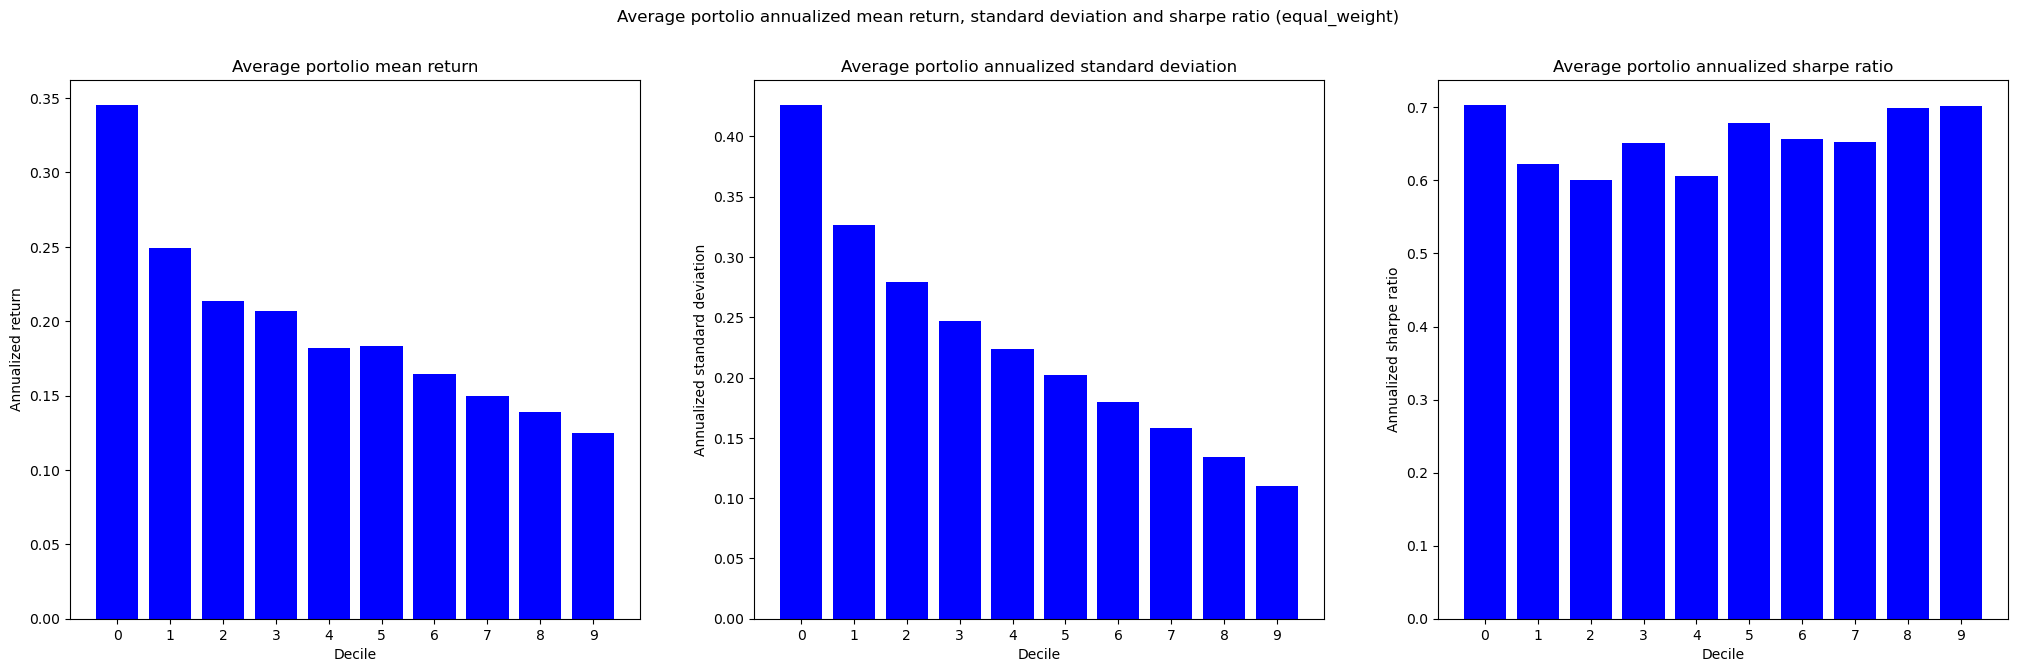

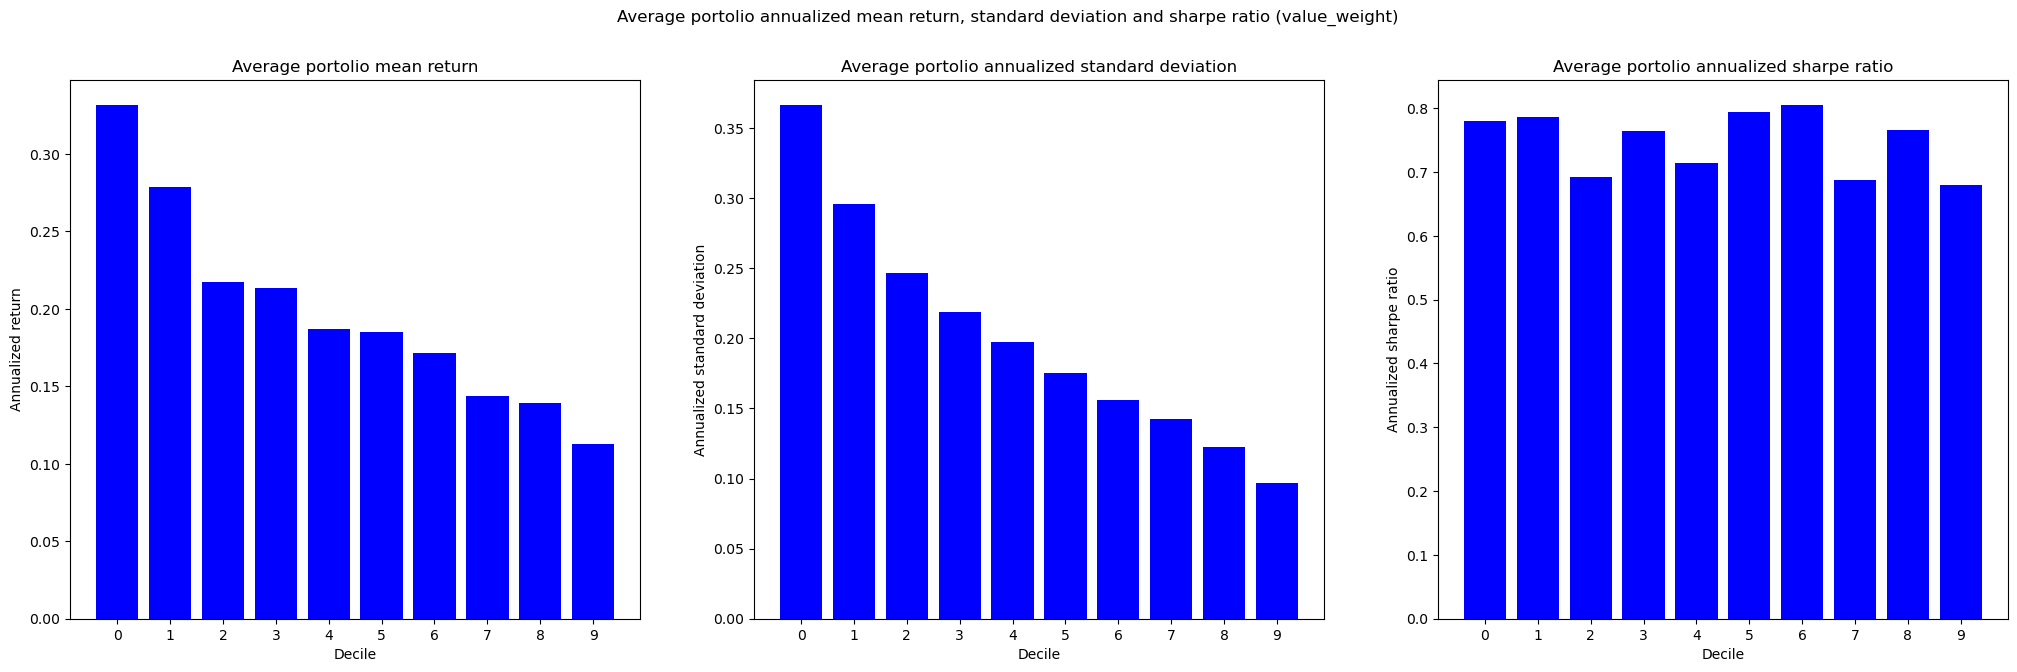

In [17]:
plot_mean_std_sr(
    data=data_Qb,
    EW = True, 
    VW = False, 
    question = '3b',
    plot_name= 'equal_weight', 
    show = True
)

plot_mean_std_sr(
    data=data_Qb,
    EW = False, 
    VW = True, 
    question = '3b',
    plot_name= 'value_weight', 
    show = True
)

## Question c)

### Prepare data for BAB

In [6]:
data_bab = Data_instance.get_rolling_beta().copy().dropna() # Create a separate dataset for the BAB question
data_bab.head()

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
37,10001,2013-01-31,0.062701,8157.0,9.87,4925,0.000051,0.054142,0.054091,0.062650,2.069056
38,10001,2013-02-28,0.011651,8157.0,9.94,4925,0.000040,0.008282,0.008242,0.011611,1.989376
39,10001,2013-03-28,0.030684,8157.0,10.20,4925,0.000034,0.035295,0.035261,0.030650,1.990010
45,10001,2013-09-30,0.004412,10372.0,10.20,4925,0.000017,0.037497,0.037480,0.004395,2.011263
49,10001,2014-01-31,0.147572,10452.0,9.17,4925,0.000042,-0.030020,-0.030062,0.147530,2.246631


### Built the function for determining BAB weights

In [85]:
def get_bab_weights(data):
    """Computes the weights of the Betting-Against-Beta portfolio."""
    df = data.copy()
    df['z'] = df.groupby('date')['beta'].rank()                     # Assign each beta a rank, for each month
    df['z_mean'] = df.groupby('date')['z'].transform('mean')        # Calculate the monthly mean the rank
    df['norm'] = np.abs(df['z']- df['z_mean'])                      # Compute abs distance of rank to mean rank
    df['sum_norm'] = df.groupby('date')['norm'].transform("sum")    # Sum the distance
    df['k'] = 2 / df['sum_norm']                                    # Compute the k

    # Compute the BAB weights
    df['wH'] = df['k'] * np.maximum(0, df['z'] - df['z_mean'])      
    df['wL'] = df['k'] * np.minimum(0, df['z'] - df['z_mean'])

    # Drop irrelevant columns
    df = df.drop(columns=["z_mean", 'z', 'norm', 'sum_norm', 'k'])

    # Compute the weighted betas
    df['bH'] = df['wH'] * df['beta']
    df['bL'] = df['wL'] * df['beta']

    # Compute the individual returns of the portfolios H and L
    df['rH'] = df['wH'] * df['ret']
    df['rL'] = df['wL'] * df['ret']

    # Compute the individual excess returns of the portfolios H and L
    # df['rHe'] = df['rH'] - df['tmytm']
    # df['rLe'] = df['rL'] - df['tmytm']

    # Compute the return and betas of the two portfolios for each period
    df_ = df.groupby('date')[['rH', 'rL', 'bH', 'bL']].sum().reset_index()                # Get the value for each period
    df_rf = df.groupby('date')[['date', 'tmytm', 'Rm_e']].first()[['tmytm','Rm_e']]       # Dataframe for the risk free rate
    df_ = pd.merge(df_, df_rf, on = 'date')                                               # Merge the risk-free rate

    # Finally create the BAB portfolio return
    df_['rBAB'] = (df_['rH'] - df_['tmytm']) / df_['bH'] - (df_['rL'] - df_['tmytm']) / df_['bL']

    return df_

In [86]:
# Create the weights rBAB
data_BAB = get_bab_weights(data_bab)
display(data_BAB)

,date,rH,rL,bH,bL,tmytm,Rm_e,rBAB
0,1964-04-30,0.007463,0.010478,1.667298,-0.501657,0.002801,0.001806,0.018101
1,1964-08-31,0.004809,0.016205,1.642998,-0.498138,0.002724,-0.013990,0.028332
2,1964-09-30,0.025464,-0.049743,1.660123,-0.496657,0.002941,0.027539,-0.092508
3,1964-10-30,0.012172,-0.021280,1.645884,-0.496355,0.002860,0.006009,-0.042977
4,1964-11-30,0.011476,0.013595,1.624228,-0.491623,0.002983,0.000107,0.026815
...,...,...,...,...,...,...,...,...
256,2022-12-30,-0.025005,0.074616,1.892106,-0.544022,0.003332,-0.060452,0.116055
257,2023-02-28,-0.014215,0.028021,1.902532,-0.539368,0.003689,-0.028355,0.035702
258,2023-06-30,0.054100,-0.122487,1.848675,-0.538885,0.004311,0.061872,-0.208365
259,2023-08-31,-0.022535,0.050269,1.873971,-0.544682,0.004473,-0.025078,0.069665


### Get the return, std and sharpe ratio of the BAB strategy

In [95]:
BAB_ret = data_BAB.rBAB.mean() * 12
BAB_std = data_BAB.rBAB.std() * np.sqrt(12)
BAB_rfr = data_BAB.tmytm.mean() * 12
BAB_shr = (BAB_ret - BAB_rfr) / BAB_std

# Compute the CAPM alpha
data_BAB['one'] = 1 # Create the column for the constant
model = sm.OLS(data_BAB['rBAB'], data_BAB[['one', 'Rm_e']]).fit() # Fit CAPM

print("Betting-against-beta strategy")
print(" - Mean return: {:.2f}%".format(BAB_ret * 100))
print(" - Standard deviation: {:.2f}%".format(BAB_std * 100))
print(" - Sharpe ratio: {:.2f}".format(BAB_shr))
print(" - CAPM alpha: {:.2f}".format(model.params.iloc[0] * 12))


Betting-against-beta strategy
 - Mean return: -51.60%
 - Standard deviation: 52.79%
 - Sharpe ratio: -1.06
 - CAPM alpha: -0.31


# 4 Momentum Strategy

## Question a)

In [4]:
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [5]:
# Add a column for momentum return (last 12months, excluding last month)
# data.index = data[['date', 'permno']]
# data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['permno', 'date'], inplace=True)

display(data)
data_mom = data.copy()
data_mom.sort_values(['date'])
data_mom['roll_ret'] = data_mom.groupby('permno').ret.transform(lambda x: x.rolling(11, closed='left').sum())
display(data_mom)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
103,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475
102,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172
101,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744
100,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668
99,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036
...,...,...,...,...,...,...,...,...
1439115,93426,2023-08-31,-0.037156,12581.0,36.0200,3676,0.004473,-0.020605
1439113,93426,2023-09-29,-0.067740,12581.0,33.5800,3676,0.004482,-0.047390
1439111,93426,2023-10-31,-0.108993,12581.0,29.9200,3676,0.004485,-0.028867
1439109,93426,2023-11-30,0.019051,12510.0,30.4900,3676,0.004465,0.092057


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret
103,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475,NaN
102,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172,NaN
101,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744,NaN
100,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668,NaN
99,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036,NaN
...,...,...,...,...,...,...,...,...,...
1439115,93426,2023-08-31,-0.037156,12581.0,36.0200,3676,0.004473,-0.020605,0.142511
1439113,93426,2023-09-29,-0.067740,12581.0,33.5800,3676,0.004482,-0.047390,0.242924
1439111,93426,2023-10-31,-0.108993,12581.0,29.9200,3676,0.004485,-0.028867,0.034596
1439109,93426,2023-11-30,0.019051,12510.0,30.4900,3676,0.004465,0.092057,-0.276471


In [ ]:
# Create deciles for the momentum returns
data_mom['decile_mom'] = data_mom.groupby('date')['roll_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
display(data_mom.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret,decile_mom
94,10001,2009-12-31,0.162621,4361.0,10.3000,4925,0.000032,0.028475,NaN,NaN
93,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,0.000013,-0.037172,NaN,NaN
92,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.000061,0.034744,NaN,NaN
91,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.000112,0.063668,NaN,NaN
90,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.000118,0.020036,NaN,NaN


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,roll_ret,decile_mom,monthly_return_EW
485488,33144,1967-01-31,0.230769,582.0,4.00000,6149,0.003795,0.085530,0.127063,8.0,0.141078
1208761,78963,2003-03-31,0.106807,84898.0,20.00000,5621,0.000951,0.010321,0.144257,8.0,0.141546
1341522,87349,2005-03-31,-0.374648,61925.0,2.22000,4812,0.002168,-0.016944,-0.285335,0.0,-0.507995
1269207,82651,2013-02-28,0.012559,85887.0,92.72000,3826,0.000040,0.008282,0.032332,3.0,0.062495
1129847,75241,1998-08-31,-0.251429,100424.0,14.68750,1311,0.003917,-0.157860,-0.610439,0.0,-0.717704
1323427,86063,2005-02-28,-0.230769,41679.0,0.10000,7374,0.002083,0.022646,-0.911472,0.0,-0.500957
1406467,91207,2009-02-27,-0.233466,183005.0,11.59000,7011,0.000144,-0.100166,-0.944861,1.0,-1.013419
774392,48063,1990-11-30,-0.187500,12394.0,-0.40625,5271,0.005558,0.065742,-0.416725,3.0,-0.402735
37216,11415,2005-03-31,0.022832,102627.0,48.83000,2834,0.002168,-0.016944,0.105893,4.0,0.102834
874370,53268,1998-08-31,-0.061539,10743.0,3.81250,5013,0.003917,-0.157860,-0.296315,1.0,-0.332877


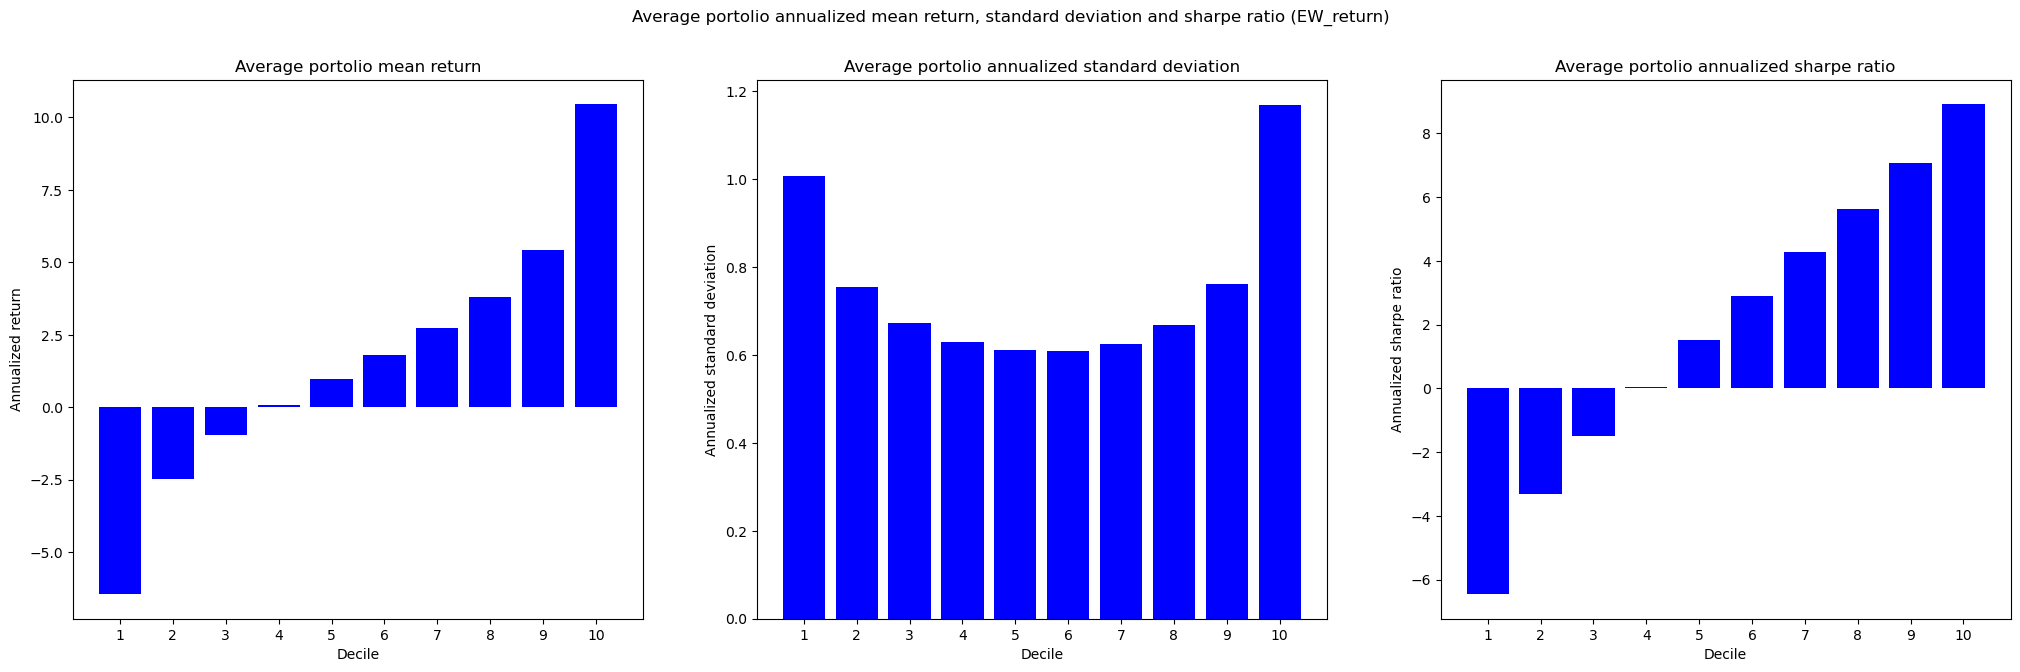

In [ ]:
data_mom["monthly_return_EW"] = data_mom.groupby(["date", "decile_mom"])["roll_ret"].transform("mean")
data_mom.dropna(axis = 0, inplace=True)
display(data_mom.sample(60))

plot_return_std_SR_deciles(data_mom, 'decile_mom', 'monthly_return_EW', 'EW_return', '4a')